<a href="https://colab.research.google.com/github/AlbertMarquillas/TFM/blob/main/Deteccion_Tenis_De_Mesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Obtención de estadisticos en tenis de mesa**


### **Inicialización**

Includes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

import torch

from os import walk

import datetime
import matplotlib.dates as mdates

In [ ]:
!pip install youtube-dl

     |████████████████████████████████| 1.9MB 4.0MB/s 


Importar repositorios de github

In [ ]:
# Repositorio propio para ciertos documentos

!git clone https://github.com/AlbertMarquillas/TFM

from TFM.PixelMetro import *

Cloning into 'TFM'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 81 (delta 27), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [ ]:
# Repositorio de yolo v5

!git clone https://github.com/ultralytics/yolov5  

%cd yolov5

%pip install -qr requirements.txt 

#from IPython.display import Image, clear_output  # to display images

Cloning into 'yolov5'...
remote: Enumerating objects: 7177, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 7177 (delta 170), reused 192 (delta 110), pack-reused 6894
Receiving objects: 100% (7177/7177), 9.20 MiB | 16.36 MiB/s, done.
Resolving deltas: 100% (4908/4908), done.
/content/yolov5
     |████████████████████████████████| 645kB 4.3MB/s 


In [ ]:
# Get weights
!gdown 'https://drive.google.com/uc?id=17YsvBipQpYZBnc16W5uKH1uzWo33UqFp' -O best.pt

Downloading...
From: https://drive.google.com/uc?id=17YsvBipQpYZBnc16W5uKH1uzWo33UqFp
To: /content/yolov5/best.pt
94.6MB [00:00, 103MB/s] 


### **Obtener información del video y reconvertirlo**

Obtener video

In [ ]:
# Test
#id = '1l_wLDG5xVNDP8FRtFz4dLnfGRbWyywup' #Video test 2 - 30 s - ok
#id = '1oxJ662f1u625oFDoWuv08Xz7UmsozXRM' #Video test 5 - 30 s - ok
id = '1bqfHwIAMIZvJvkCeHHcdRaukRENYtcVM' #Video test 7 - 30 s - ok
#id = '1X-Hx5DuoXkZ1-fHnnAYsttoRnQrsIqTS' #Video test 7 - 30 s - 720p - ok
#id = '17YrwMk6x_vXj0ao9X7dld-l5UJyDPGHQ' #Video test 7 - 30 s - 480p - ok
#id = '1OlggX5U0yO1Edkv5TI7CCzQWS28uf1ce' #Video test 7 - 30 s - 360p - ok

# External video OK
#id = '1uQl3NZffRm1DOnI1k6azsb1zeu-mcgXw' #WTT - 1 min - ok
#id = '1cfHwLR5VKNn5xWX7lml0CIqW8H8zG-rI' #WTT (black) - 1 min - ok
#id = '1MbbNjMfk1VnIs0uzjf-s3FS56EkWjEvH' #RFETM - 1 min - 

# Extenal video no OK
#id = '1QgLX25A8RzyDw7QJlyYNKkh1nCFo-A1k' #Baja calidad + Diagonal - 1 min - ok
#id = '1F5rs2ueRiuiB7WwLs1Y5DooBA5gIW9b0' #Movimiento camara - 1 min - ok

# YouTube Videos
#id = 'IqfLSKQam30'
#id = 'q8ScTxP2Iv8'
#id = 'fPHnr1ZFXWs'

if len(id) == 33:
  youtube = False
else:
  youtube = True

In [ ]:
!rm video.mp4
if youtube == False:
  !gdown 'https://drive.google.com/uc?id='$id -O video.mp4
else:
  link = 'https://www.youtube.com/watch?v='+id
  !youtube-dl -f 'bestvideo[ext=mp4]' --output "video.%(ext)s" $link

Downloading...
From: https://drive.google.com/uc?id=1bqfHwIAMIZvJvkCeHHcdRaukRENYtcVM
To: /content/yolov5/video.mp4
56.7MB [00:00, 61.7MB/s]


Reconveritr el video

In [ ]:
new_fps = 0

if new_fps > 0:
  !mv video.mp4 video_conv.mp4
  !ffmpeg -i video_conv.mp4 -filter:v fps=$new_fps video.mp4
  !rm video_conv.mp4

In [ ]:
cap = cv2.VideoCapture('./video.mp4')

fps = cap.get(cv2.CAP_PROP_FPS)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

print(fps,length, width, height)

120.0 3610 1920.0 1080.0


### **Detección**

In [ ]:
!python detect.py --weights best.pt --img 640 --conf 0.25 --source ./video.mp4 --save-conf --save-txt --save-crop

### **Obtener estadísticos**

Determinar los labels

In [ ]:
_, folders, _ = next(walk('./runs/detect/'))

last_exp = sorted(sorted(folders), key=len)[-1]

In [ ]:
def areaOverlap(r1,r2):
  r1 = [r1[0]-r1[2]/2,r1[1]-r1[3]/2,r1[0]+r1[2]/2,r1[1]+r1[3]/2]
  r2 = [r2[0]-r2[2]/2,r2[1]-r2[3]/2,r2[0]+r2[2]/2,r2[1]+r2[3]/2]
  x11,y11,x12,y12 = r1
  x21,y21,x22,y22 = r2
  x_overlap = max(0, min(x12,x22) - max(x11,x21))
  y_overlap = max(0, min(y12,y22) - max(y11,y21))
  overlapArea = x_overlap * y_overlap
  return overlapArea

def rect_iou(r1,r2):
  intersect = areaOverlap(r1,r2)
  union = (r1[2]*r1[3]) + (r2[2]*r2[3]) - intersect
  return intersect/union
  

def calcArea(rect):
  #rect = [rect[0]-rect[2]/2,rect[1]-rect[3]/2,rect[0]+rect[2]/2,rect[1]+rect[3]/2]
  #x1,x2,y1,y2 = rect
  #return abs(x1-x2) * abs(y1-y2)
  w = rect[2]
  h = rect[3]
  return w*h


In [ ]:
path = './runs/detect/'+last_exp+'/labels/'
_, _, filenames = next(walk(path))

files = sorted(sorted(filenames), key=len)

detect_table = True
detect_players = True
detect_ball = True

init_point = [-1,-1,0,0]
last_j1 = init_point
last_j2 = init_point
last_ball = init_point
pl1_points = []
pl2_points = []
mesas = []
secRefresh_mesa = -1

tables_count = 0

if secRefresh_mesa < 0: 
  n = length 
else: 
  n = int(fps*secRefresh_mesa)
  if n == 0:
    n = 1

best_tables = []
tables_prov = []
iterations = 0

all_balls = [[init_point, -1,-1]]
balls_ok = []

for i in files:
    file = open(path+i,"r")
    detections = file.readlines()
    file.close()
    players = []
    balls = []
    tables = []
    max_pl = init_point
    max_pl2 = init_point
    
    for det in detections:
        val = det.split()
        # val 0:id 1:x 2:y 3:w 4:h 5:conf
        if int(val[0]) == 0:
            players += [det]
            detect_players = True
            #print("jugador")
        elif int(val[0]) == 13:
            tables += [det]
            detect_table = True
            #print("mesa")
        elif int(val[0]) == 32:
            balls += [det]
            detect_ball = True
            #print("pelota")
      
    if detect_players == True:
      pj1 = init_point
      pj2 = init_point
      for pl in players:
        pl = list(map(float,pl.split()))[1:5]
        # Check biggest
        if pl[2]*pl[3] > max_pl[2]*max_pl[3]:
          if max_pl != init_point:
            max_pl2 = max_pl
          max_pl = pl
        elif pl[2]*pl[3] > max_pl2[2]*max_pl2[3]:
          max_pl2 = pl
        # Check players
        if last_j1 == init_point:
          pj1 = pl
          last_j1 = pl
        elif last_j2 == init_point:
          pj2 = pl
          last_j2 = pl
        elif pj1 == init_point and pj2 == init_point:
          if rect_iou(last_j1,pl) > 0 and rect_iou(last_j1,pl) > rect_iou(last_j2,pl): #IOU
            pj1 = pl
          elif rect_iou(last_j2,pl) > 0:
            pj2 = pl
          else:
            d1 =math.sqrt((last_j1[0]-pl[0])**2 + (last_j1[1]-pl[1])**2)
            d2 =math.sqrt((last_j2[0]-pl[0])**2 + (last_j2[1]-pl[1])**2)
            if d1 < d2:
              pj1 = pl
            else:
              pj2 = pl
          #  pj1 = last_j1 #rm
          #  pj2 = last_j2 #rm
        elif pj1 == init_point or pj2 == init_point:
          if last_j1 == init_point:
            pj1 = pl
            last_j1 = pl
          elif last_j2 == init_point:
            pj2 = pl
            last_j2 = pl
          elif rect_iou(last_j1,pl) > 0:
            pj1 = pl
          elif rect_iou(last_j2,pl) > 0:
            pj2 = pl
        else:
          if (calcArea(pl) > calcArea(pj1)) and (calcArea(pl) > calcArea(pj2)):
            if calcArea(pj1) > calcArea(pj2):
              pj2 = pl
            else:
              pj1 = pl
          elif calcArea(pl) > calcArea(pj1):
            pj1 = pl
            #if calcArea(pl) > calcArea(pj2):
            #  if areaOverlap(last_j1,pl) < areaOverlap(last_j2,pl):
            #    pj2 = pl
            #else:
            #  if areaOverlap(last_j2,pl) < areaOverlap(last_j1,pl):
            #    pj1 = pl
          elif calcArea(pl) > calcArea(pj2):
            pj2 = pl
            #if calcArea(pl) > calcArea(pj1):
            #  if areaOverlap(last_j2,pl) < areaOverlap(last_j1,pl):
            #    pj1 = pl
            #else:
            #  if areaOverlap(last_j1,pl) < areaOverlap(last_j2,pl):
            #    pj2 = pl
        #print(pj1)

      if (pj1 != init_point):
        last_j1 = pj1
      if (pj2 != init_point):
        last_j2 = pj2

      # Jugadores conf + logic
      # separar left i right
      # + Media
      # pts_j1 = []
      # pts_j2 = []
      #Mesa detected?
      #Obtener punto origne y punto destino
      #p1 = (100, 300)
      #p2 = (101, 300)
      #getMeters(p1,p2,l1,l2,l3,l4)
      #detect_players = False

    pl1_points += [last_j1]
    pl2_points += [last_j2]

    if detect_table == True:
      for t in tables:
        t = list(map(float,t.split()))[1:5]
        area = float(areaOverlap(t,max_pl))
        area2 = float(areaOverlap(t,max_pl2))
        #print(area, area2, tables_count, max_pl, max_pl2)
        tables_prov += [[t,area, area2,tables_count]]
        tables_count += 1
        if ((1+iterations) % n) == 0:
          best_t = init_point
          min_area = 1000000
          min_area2 = 1000000
          val = -1
          for tb in tables_prov:
            if tb[1] == min_area and tb[2] == min_area2:
              if tb[0][2]*tb[0][3] < best_t[2]*best_t[3]:
                min_area = tb[1]
                min_area2 = tb[2]
                best_t = tb[0]
                val = tb[3]
            elif tb[1] <= min_area:
              if tb[2] <= min_area2:
                min_area = tb[1]
                min_area2 = tb[2]
                best_t = tb[0]
                val = tb[3]
          best_tables += [[(best_t[0]-(best_t[2]/2))*width,(best_t[1]-(best_t[3]/2))*height,val]]
          tables_prov = []

      # Check best mesa of 10 .. 20 frames menos colindante con jugador más grande
      #img = cv2.imread("./taula4.JPG")
      #lines = getLines(img)
      #a,b,c,d = getRectangle(img,lines)
      # Obtener escala x y y
      #x = 350
      #y = 400
      #l1,l2,l3,l4 = scalePoints(x,y,a,b,c,d)
      #detect_table = False

    if detect_ball == True:
      if balls == []:
        all_balls += [[init_point, iterations,-1]]
      for b in balls:
        equal_balls = 0
        b = list(map(float,b.split()))[1:5]
        for x in all_balls[-30:]:
            if (areaOverlap(b,x[0]) / (b[2]*b[3])) > 0.7:
              equal_balls += 1
        all_balls += [[b,iterations,equal_balls]]
      # Max conf + logic
      # + Media
      # pts_pelota = []
      # Obtener punto origne y punto destino
      #p1 = (100, 300)
      #p2 = (101, 300)
      #getMeters(p1,p2,l1,l2,l3,l4)
      #detect_ball = False
    iterations += 1

all_balls_sum = []
for ball in reversed(all_balls):
  equal_balls = 0
  b = ball[0]
  if b == init_point:
    all_balls_sum += [ball]
    continue
  for x in all_balls_sum[-30:]:
     if (areaOverlap(b,x[0]) / (b[2]*b[3])) > 0.7:
        equal_balls += 1
  if ball[2]+equal_balls < 10:
    all_balls_sum += [[b,ball[1],ball[2]+equal_balls]]
  else:
    all_balls_sum += [[init_point,ball[1],-1]]

all_balls = all_balls_sum[::-1]

for i in range(len(all_balls)):
  if i+1 < len(all_balls):
    while all_balls[i][1] == all_balls[i+1][1]:
      i += 1
      if i+1+1 > len(all_balls):
        break
    else:
      balls_ok += [all_balls[i+1][0]]

if best_tables == []:
  best_t = init_point
  min_area = 1000000
  min_area2 = 1000000
  val = -1
  for tb in tables_prov:
    if tb[1] == min_area and tb[2] == min_area2:
      if tb[0][2]*tb[0][3] < best_t[2]*best_t[3]:
        min_area = tb[1]
        min_area2 = tb[2]
        best_t = tb[0]
        val = tb[3]
    elif tb[1] <= min_area:
      if tb[2] <= min_area2:
        min_area = tb[1]
        min_area2 = tb[2]
        best_t = tb[0]
        val = tb[3]
  best_tables += [[(best_t[0]-(best_t[2]/2))*width,(best_t[1]-(best_t[3]/2))*height,val]]

Graficos

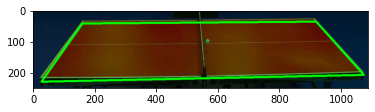

In [ ]:
time = []
t = 0
tab = []

dist_j1 = []
cumul_j1 = []
cu_j1 = 0
vel_j1 = []
last_pl1 = init_point
ct1 = 1

dist_j2 = []
cumul_j2 = []
cu_j2 = 0
vel_j2 = []
last_pl2 = init_point
ct2 = 1

dist_ball = []
cumul_ball = []
cu_ball = 0
vel_ball = []
last_ball = init_point
ctb = 1

for i in range(len(files)):
  time += [str(datetime.timedelta(seconds=(t)))]
  t += 1/fps

  if tab != best_tables[int(i/n)]:
    tab = best_tables[int(i/n)]
    x,y,v = tab
    if v==0:
      name_table = "./runs/detect/"+last_exp+"/crops/mesa/video.jpg"
    else:
      name_table = "./runs/detect/"+last_exp+"/crops/mesa/video"+str(v)+".jpg"
    img = cv2.imread(name_table)
    a,b,c,d = get_Table(img,True)
    l1,l2,l3,l4 = scalePoints(x,y,a,b,c,d)

  if pl1_points[i] == init_point:
    ct1 += 1
    if last_pl1 == init_point:
      dist_j1 += [0]
      vel_j1 += [0]
    else:
      dist_j1 += [0]
      vel_j1 += [0]
  else:
    
    if last_pl1 == init_point:
      last_pl1 = pl1_points[i]
      dist_j1 += [0]
      vel_j1 += [0]
    elif ct1 > fps:
      dist_j1 += [0]
      vel_j1 += [0]
    elif pl1_points[i] == last_pl1:
      dist_j1 += [0]
      vel_j1 += [0]
    else:
      p1 = (pl1_points[i][0]*width,pl1_points[i][1]*height)
      p2 = (last_pl1[0]*width,last_pl1[1]*height)
      dist = getMeters(p1,p2,l1,l2,l3,l4)/3.5/(ct1+1)
      if dist*fps > 15:
        dist = 0
      cu_j1 += dist
      dist_j1 += [dist]
      vel_j1 += [dist*fps]
    last_pl1 = pl1_points[i]
    ct1 = 0
  cumul_j1 += [cu_j1]

  if pl2_points[i] == init_point:
    ct2 += 1
    if last_pl2 == init_point:
      dist_j2 += [0]
      vel_j2 += [0]
    else:
      dist_j2 += [0]
      vel_j2 += [0]
  else:
    if last_pl2 == init_point:
      last_pl2 = pl2_points[i]
      dist_j2 += [0]
      vel_j2 += [0]
    elif ct2 > fps:
      dist_j2 += [0]
      vel_j2 += [0]
    elif pl2_points[i] == last_pl2:
      dist_j2 += [0]
      vel_j2 += [0]
    else:
      p1 = (pl2_points[i][0]*width,pl2_points[i][1]*height)
      p2 = (last_pl2[0]*width,last_pl2[1]*height)
      dist = getMeters(p1,p2,l1,l2,l3,l4)/3.5/(ct2+1)
      if dist*fps > 15:
        dist = 0
      cu_j2 += dist
      dist_j2 += [dist]
      vel_j2 += [dist*fps]
    last_pl2 = pl2_points[i]
    ct2 = 0
  cumul_j2 += [cu_j2]

  if balls_ok[i] == init_point:
    ctb += 1
    if last_ball == init_point:
      dist_ball += [0]
      vel_ball += [0]
    else:
      dist_ball += [0]
      vel_ball += [0]
  else:
    if last_ball == init_point:
      last_ball = balls_ok[i]
      dist_ball += [0]
      vel_ball += [0]
    elif ctb > fps/2:
      dist_ball += [0]
      vel_ball += [0]
    elif balls_ok[i] == last_ball:
      dist_ball += [0]
      vel_ball += [0]
    else:
      p1 = (balls_ok[i][0]*width,balls_ok[i][1]*height)
      p2 = (last_ball[0]*width,last_ball[1]*height)
      dist = getMeters(p1,p2,l1,l2,l3,l4)/2/(ctb+1)
      if dist*fps > 80:
        dist = 0
      cu_ball += dist
      dist_ball += [dist]        
      vel_ball += [dist*fps]
    last_ball = balls_ok[i]
    ctb = 0
  cumul_ball += [cu_ball]

time = pd.to_datetime(time)

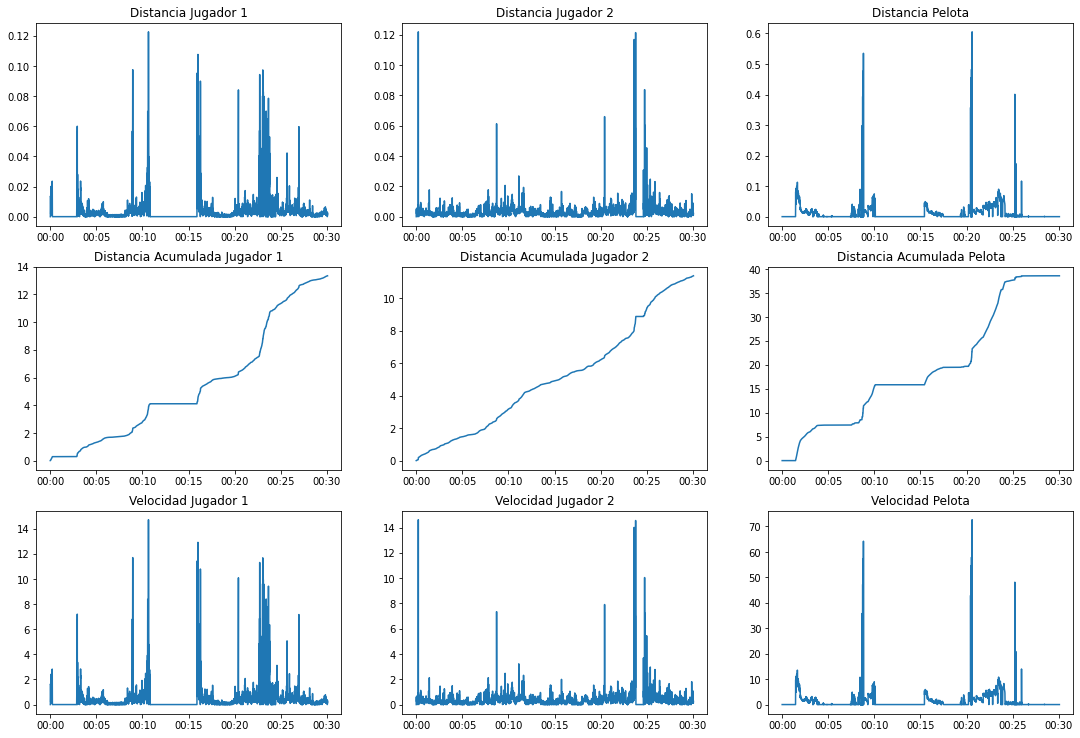

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (18,12))
axs[0, 0].plot(time, dist_j1)
axs[0, 0].set_title('Distancia Jugador 1')
axs[0, 1].plot(time, dist_j2)
axs[0, 1].set_title('Distancia Jugador 2')
axs[0, 2].plot(time, dist_ball)
axs[0, 2].set_title('Distancia Pelota')
axs[1, 0].plot(time, cumul_j1)
axs[1, 0].set_title('Distancia Acumulada Jugador 1')
axs[1, 1].plot(time, cumul_j2)
axs[1, 1].set_title('Distancia Acumulada Jugador 2')
axs[1, 2].plot(time, cumul_ball)
axs[1, 2].set_title('Distancia Acumulada Pelota')
axs[2, 0].plot(time, vel_j1)
axs[2, 0].set_title('Velocidad Jugador 1')
axs[2, 1].plot(time, vel_j2)
axs[2, 1].set_title('Velocidad Jugador 2')
axs[2, 2].plot(time, vel_ball)
axs[2, 2].set_title('Velocidad Pelota');

myFmt = mdates.DateFormatter('%M:%S')
for i in range(3):
  for j in range(3):
    axs[i,j].xaxis.set_major_formatter(myFmt)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

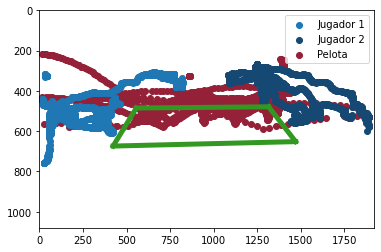

In [ ]:
pos_x = []
pos_y = []
for [x,y,_,_] in balls_ok:
  if x!=-1:
    pos_x += [x*width]
    pos_y += [y*height]
b = plt.scatter(pos_x,pos_y, c = '#942137')

pos_x = []
pos_y = []
for [x,y,_,_] in pl1_points:
  if x!=-1:
    pos_x += [x*width]
    pos_y += [y*height]
p1 = plt.scatter(pos_x,pos_y, c = '#1f77b4')

pos_x = []
pos_y = []
for [x,y,_,_] in pl2_points:
  if x!=-1:
    pos_x += [x*width]
    pos_y += [y*height]
p2 = plt.scatter(pos_x,pos_y, c = '#154872')

plt.plot([l1[0],l1[2]],[l1[1],l1[3]],c='#329821', linewidth = 5)
plt.plot([l2[0],l2[2]],[l2[1],l2[3]],c='#329821', linewidth = 5)
plt.plot([l3[0],l3[2]],[l3[1],l3[3]],c='#329821', linewidth = 5)
plt.plot([l4[0],l4[2]],[l4[1],l4[3]],c='#329821', linewidth = 5)

plt.legend((p1,p2,b),('Jugador 1','Jugador 2','Pelota'))
plt.xlim([0, width])
plt.ylim([height, 0])
plt.show()

In [ ]:
times = 0

for x in vel_ball:
  if x > 0:
    times += 1

print("El total de tiempo de juego es de: "+str((int(times*100/fps))/100)+"s")
print("El procentaje de tiempo de juego es: "+str(int(times*100/length))+"%")

El total de tiempo de juego es de: 11.42s
El procentaje de tiempo de juego es: 37%
